# UMAP project

## Imports

In [1]:
# standard lib
import os
import warnings

# 3rd party lib
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import umap
from sklearn.preprocessing import LabelEncoder, StandardScaler, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.cluster import HDBSCAN
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, ColorBar, BasicTicker
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis4, Viridis3
from bokeh.layouts import column
from bokeh.models import ColorMapper

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

/home/isidora/miniconda3/envs/ml-proj/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/isidora/miniconda3/envs/ml-proj/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/isidora/miniconda3/envs/ml-proj/lib/python3.9/site-packages/

In [2]:
def histogram(df, param, bins=100, cmap='gist_rainbow'):
    cls_list = df['class'].unique()
    colormap = plt.get_cmap(cmap, len(cls_list))
    for i,cls in enumerate(cls_list):
        x = df.loc[df['class'] == cls, param]
        color = colormap(i)
        plt.hist(x.loc[(x.quantile(0.0)<x) & (x<x.quantile(0.97))], bins, facecolor=color, alpha=0.5, label=f'{cls}, count={x.shape[0] - x.isna().sum()}')
    plt.legend()
    plt.xlabel(param,size=12)
    plt.show()
    
def histogram_grid(df, size=(3,3), features=['psMag_u','psMag_g','psMag_r','psMag_i'], bins=100, cmap='plasma'):
    
    fig = plt.figure(constrained_layout=True, figsize=(8, 8))
    nrows, ncols = size
    spec = gridspec.GridSpec(ncols=ncols,nrows=nrows,figure=fig)

    cls_list = df['class'].unique()
    colormap = plt.get_cmap(cmap, len(cls_list))
    
    axes = []
    for i in np.arange(0, ncols):
        for j in np.arange(0, nrows):
            ax = fig.add_subplot(spec[j, i])
            #ax.xaxis.set_ticks([])
            ax.yaxis.set_ticks([])
            axes.append(ax)

    for idx in range(nrows*ncols):
        for i,cls in enumerate(cls_list):
            x = df.loc[df['class'] == cls, features[idx]]
            color = colormap(i)
            axes[idx].hist(x.loc[(x.quantile(0.0)<x) & (x<x.quantile(0.97))], bins, facecolor=color, alpha=0.5, label=f'{cls}, count={x.shape[0] - x.isna().sum()}')
        axes[idx].set_xlabel(features[idx])
        if idx == 0:
            axes[idx].legend(fontsize=8)

def prep(X,y, test_size=0.3, random_state=7):
    
    "Prepare data for model fitting: train-test split and standardization"
    
    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    
    #standardization using StandardScaler applied to X_train and then scaling X_train and X_test
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

## Učitavanje podataka

In [3]:
# Data challenge root data dir
data_dir = "./data/"

# Read the object table
object_df = pd.read_parquet(os.path.join(data_dir, 's82ObjectTable.parquet'))
print(object_df.shape)
object_df.describe()

(442694, 383)


,ra,dec,psPm_ra,psPm_dec,psParallax,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPeriodic[6]_u,lcNonPeriodic[6]_g,lcNonPeriodic[6]_r,lcNonPeriodic[6

In [4]:
object_df['class'].value_counts()

class
s82Gal      246409
s82Star      94257
s82Qso       83881
s82vStar     16110
highZQso      1089
s82Agn         948
Name: count, dtype: int64

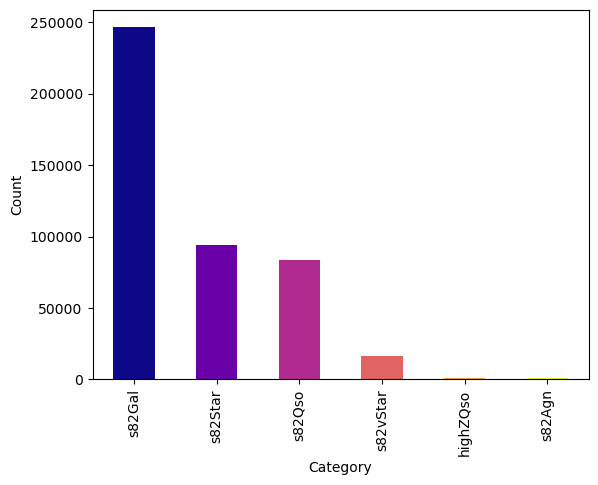

In [5]:
cmap = cm.get_cmap('plasma')
num_colors = 6
colors = [cmap(i) for i in np.linspace(0, 1, num_colors)]
object_df['class'].value_counts().plot(kind='bar',color=colors)
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [6]:
object_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 442694 entries, 0271386 to 1468021
Data columns (total 383 columns):
 #    Column               Non-Null Count   Dtype  
---   ------               --------------   -----  
 0    ra                   442694 non-null  float64
 1    dec                  442694 non-null  float64
 2    psPm_ra              438409 non-null  float64
 3    psPm_dec             438409 non-null  float64
 4    psParallax           133977 non-null  float64
 5    psMag_u              338632 non-null  float64
 6    psMag_g              428910 non-null  float64
 7    psMag_r              431293 non-null  float64
 8    psMag_i              430784 non-null  float64
 9    psMag_z              431616 non-null  float64
 10   psMag_y              386459 non-null  float64
 11   psFlux_u             380192 non-null  float64
 12   psFlux_g             429119 non-null  float64
 13   psFlux_r             431311 non-null  float64
 14   psFlux_i             430794 non-null  float64
 1

In [7]:
object_df.head()

,ra,dec,psPm_ra,psPm_dec,psParallax,psMag_u,psMag_g,psMag_r,psMag_i,psMag_z,psMag_y,psFlux_u,psFlux_g,psFlux_r,psFlux_i,psFlux_z,psFlux_y,bdMag_u,bdMag_g,bdMag_r,bdMag_i,bdMag_z,bdMag_y,bdFlux_u,bdFlux_g,bdFlux_r,bdFlux_i,bdFlux_z,bdFlux_y,psMagErr_u,psMagErr_g,psMagErr_r,psMagErr_i,psMagErr_z,psMagErr_y,psFluxErr_u,psFluxErr_g,psFluxErr_r,psFluxErr_i,psFluxErr_z,psFluxErr_y,bdMagErr_u,bdMagErr_g,bdMagErr_r,bdMagErr_i,bdMagErr_z,bdMagErr_y,bdFluxErr_u,bdFluxErr_g,bdFluxErr_r,bdFluxErr_i,bdFluxErr_z,bdFluxErr_y,extendedness_u,extendedness_g,extendedness_r,extendedness_i,extendedness_z,extendedness_y,stdColor_0,stdColor_1,stdColor_2,stdColor_3,stdColor_4,stdColorErr_0,stdColorErr_1,stdColorErr_2,stdColorErr_3,stdColorErr_4,lcPeriodic[0]_g,lcPeriodic[0]_r,lcPeriodic[0]_i,lcPeriodic[1]_g,lcPeriodic[1]_r,lcPeriodic[1]_i,lcPeriodic[2]_g,lcPeriodic[2]_r,lcPeriodic[2]_i,lcPeriodic[3]_g,lcPeriodic[3]_r,lcPeriodic[3]_i,lcPeriodic[4]_u,lcPeriodic[4]_g,lcPeriodic[4]_r,lcPeriodic[4]_i,lcPeriodic[4]_z,lcPeriodic[5]_u,lcPeriodic[5]_g,lcPeriodic[5]_r,lcPeriodic[5]_i,lcPeriodic[5]_z,lcPeriodic[6]_u,lcPeriodic[6]_g,lcPeriodic[6]_r,lcPeriodic[6]_i,lcPeriodic[6]_z,lcPeriodic[7]_u,lcPeriodic[7]_g,lcPeriodic[7]_r,lcPeriodic[7]_i,lcPeriodic[7]_z,lcPeriodic[8]_u,lcPeriodic[8]_g,lcPeriodic[8]_r,lcPeriodic[8]_i,lcPeriodic[8]_z,lcPeriodic[9]_u,lcPeriodic[9]_g,lcPeriodic[9]_r,lcPeriodic[9]_i,lcPeriodic[9]_z,lcPeriodic[10]_u,lcPeriodic[10]_g,lcPeriodic[10]_r,lcPeriodic[10]_i,lcPeriodic[10]_z,lcPeriodic[11]_u,lcPeriodic[11]_g,lcPeriodic[11]_r,lcPeriodic[11]_i,lcPeriodic[11]_z,lcPeriodic[12]_u,lcPeriodic[12]_g,lcPeriodic[12]_r,lcPeriodic[12]_i,lcPeriodic[12]_z,lcPeriodic[13]_u,lcPeriodic[13]_g,lcPeriodic[13]_r,lcPeriodic[13]_i,lcPeriodic[13]_z,lcPeriodic[14]_u,lcPeriodic[14]_g,lcPeriodic[14]_r,lcPeriodic[14]_i,lcPeriodic[14]_z,lcPeriodic[15]_u,lcPeriodic[15]_g,lcPeriodic[15]_r,lcPeriodic[15]_i,lcPeriodic[15]_z,lcPeriodic[16]_u,lcPeriodic[16]_g,lcPeriodic[16]_r,lcPeriodic[16]_i,lcPeriodic[16]_z,lcPeriodic[17]_u,lcPeriodic[17]_g,lcPeriodic[17]_r,lcPeriodic[17]_i,lcPeriodic[17]_z,lcPeriodic[18]_u,lcPeriodic[18]_g,lcPeriodic[18]_r,lcPeriodic[18]_i,lcPeriodic[18]_z,lcPeriodic[19]_u,lcPeriodic[19]_g,lcPeriodic[19]_r,lcPeriodic[19]_i,lcPeriodic[19]_z,lcPeriodic[20]_u,lcPeriodic[20]_g,lcPeriodic[20]_r,lcPeriodic[20]_i,lcPeriodic[20]_z,lcPeriodic[21]_u,lcPeriodic[21]_g,lcPeriodic[21]_r,lcPeriodic[21]_i,lcPeriodic[21]_z,lcPeriodic[22]_u,lcPeriodic[22]_g,lcPeriodic[22]_r,lcPeriodic[22]_i,lcPeriodic[22]_z,lcPeriodic[23]_u,lcPeriodic[23]_g,lcPeriodic[23]_r,lcPeriodic[23]_i,lcPeriodic[23]_z,lcPeriodic[24]_u,lcPeriodic[24]_g,lcPeriodic[24]_r,lcPeriodic[24]_i,lcPeriodic[24]_z,lcPeriodic[25]_u,lcPeriodic[25]_g,lcPeriodic[25]_r,lcPeriodic[25]_i,lcPeriodic[25]_z,lcPeriodic[26]_u,lcPeriodic[26]_g,lcPeriodic[26]_r,lcPeriodic[26]_i,lcPeriodic[26]_z,lcPeriodic[27]_u,lcPeriodic[27]_g,lcPeriodic[27]_r,lcPeriodic[27]_i,lcPeriodic[27]_z,lcPeriodic[28]_u,lcPeriodic[28]_g,lcPeriodic[28]_r,lcPeriodic[28]_i,lcPeriodic[28]_z,lcPeriodic[29]_u,lcPeriodic[29]_g,lcPeriodic[29]_r,lcPeriodic[29]_i,lcPeriodic[29]_z,lcPeriodic[30]_u,lcPeriodic[30]_g,lcPeriodic[30]_r,lcPeriodic[30]_i,lcPeriodic[30]_z,lcPeriodic[31]_u,lcPeriodic[31]_g,lcPeriodic[31]_r,lcPeriodic[31]_i,lcPeriodic[31]_z,lcPeriodic[32]_u,lcPeriodic[32]_g,lcPeriodic[32]_r,lcPeriodic[32]_i,lcPeriodic[32]_z,lcNonPeriodic[0]_u,lcNonPeriodic[0]_g,lcNonPeriodic[0]_r,lcNonPeriodic[0]_i,lcNonPeriodic[0]_z,lcNonPeriodic[1]_u,lcNonPeriodic[1]_g,lcNonPeriodic[1]_r,lcNonPeriodic[1]_i,lcNonPeriodic[1]_z,lcNonPeriodic[2]_u,lcNonPeriodic[2]_g,lcNonPeriodic[2]_r,lcNonPeriodic[2]_i,lcNonPeriodic[2]_z,lcNonPeriodic[3]_u,lcNonPeriodic[3]_g,lcNonPeriodic[3]_r,lcNonPeriodic[3]_i,lcNonPeriodic[3]_z,lcNonPeriodic[4]_u,lcNonPeriodic[4]_g,lcNonPeriodic[4]_r,lcNonPeriodic[4]_i,lcNonPeriodic[4]_z,lcNonPeriodic[5]_u,lcNonPeriodic[5]_g,lcNonPeriodic[5]_r,lcNonPeriodic[5]_i,lcNonPeriodic[5]_z,lcNonPeriodic[6]_u,lcNonPeriodic[6]_g,lcNonPeriodic[6]_r,lcNonPeriodic[6

## Feature selection

In [8]:
## AGN DC SER-SAG selected features (based on histogram analysis)

ser_sag = object_df[[             
             'psMag_u','psMag_g','psMag_r','psMag_i','psMag_z','psMag_y',
             'bdMag_u','bdMag_g','bdMag_r','bdMag_i','bdMag_z','bdMag_y',
             'extendedness_u','extendedness_g','extendedness_r','extendedness_i','extendedness_z',
             'lcNonPeriodic[0]_g','lcNonPeriodic[5]_g','lcNonPeriodic[5]_r','lcNonPeriodic[9]_i',
             'lcNonPeriodic[12]_g','lcNonPeriodic[12]_u','lcNonPeriodic[13]_u','lcNonPeriodic[14]_g',
             'lcNonPeriodic[15]_u','lcNonPeriodic[15]_g','lcNonPeriodic[15]_r','lcNonPeriodic[15]_i',
             'lcNonPeriodic[15]_z','lcNonPeriodic[21]_u','lcNonPeriodic[21]_g','lcNonPeriodic[22]_g',
             'lcNonPeriodic[23]_u','lcNonPeriodic[25]_g','lcNonPeriodic[25]_r','lcNonPeriodic[25]_i',
             'lcNonPeriodic[26]_u','lcNonPeriodic[26]_g','lcNonPeriodic[26]_r','lcNonPeriodic[26]_i',
             'lcNonPeriodic[28]_g','lcNonPeriodic[28]_r','lcNonPeriodic[28]_i','lcPeriodic[4]_i',
             'lcPeriodic[4]_u','lcPeriodic[12]_g','lcPeriodic[14]_i','lcPeriodic[20]_g','lcPeriodic[28]_g',
             'lcPeriodic[28]_i','lcPeriodic[29]_g','lcPeriodic[29]_r','lcPeriodic[29]_i','lcPeriodic[30]_g',
             'lcPeriodic[30]_r','lcPeriodic[30]_i',
             'stdColor_0','stdColor_1','stdColor_2','stdColor_3','stdColor_4',
             'class',
              'z',
        ]]

ser_sag.dropna(inplace=True)
ser_sag.drop('z', inplace=True, axis=1)
print(f"Sample of size {ser_sag.shape[0]} described by {ser_sag.shape[1]} features (including class).")

Sample of size 142963 described by 63 features (including class).


In [9]:
# Testing sample (quick iterations - faster code dev)

samp_original = ser_sag.sample(n=10000, replace=False, random_state=42, ignore_index=True)

# Preimenujemo klase radi jednostavnosti + preinačujemo s82Agn u Gal i s82vStar u Star

samp = samp_original.replace({'class': {'s82Qso': 'Qso',
                             's82Agn': 'Gal',
                             'highZQso': 'Qso',
                             's82Star':'Star',
                             's82vStar':'Star',
                             's82Gal':'Gal'}})

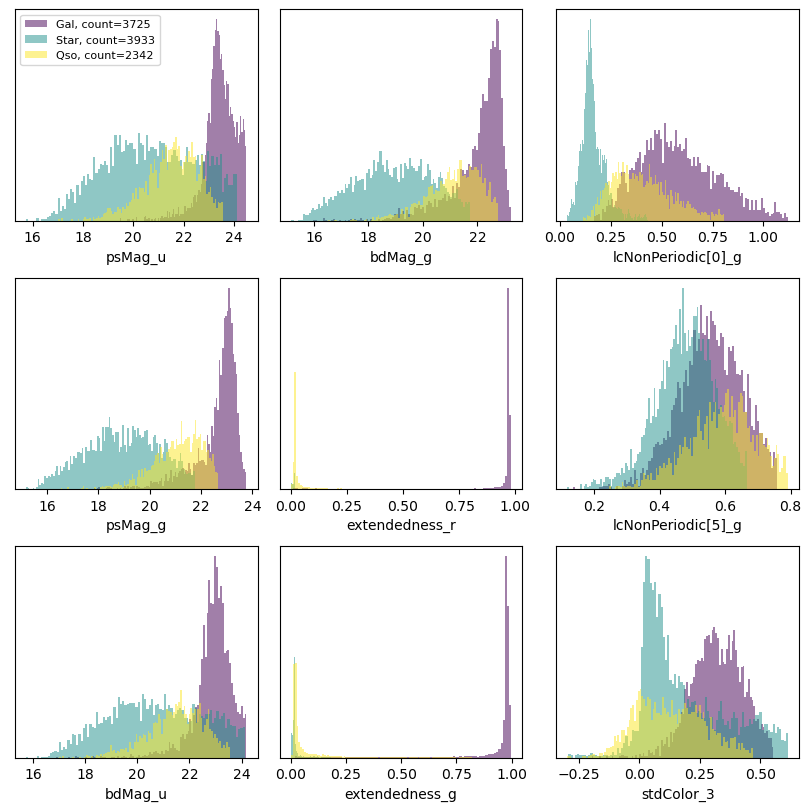

In [10]:
# Histograms for a selected group of features

histogram_grid(samp, cmap='viridis', features=['psMag_u','psMag_g',
                                  'bdMag_u','bdMag_g',
                                  'extendedness_r','extendedness_g',
                                  'lcNonPeriodic[0]_g','lcNonPeriodic[5]_g',
                                  'stdColor_3'])

## Unsupervised UMAP

In [11]:
# Preparing data format for umap and scikit-learn

sample = samp
X = sample.iloc[:,:-1]
y = sample['class']
y_old = samp_original['class']


label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
classes = label_encoder.inverse_transform(np.unique(y))

train, test, train_labels, test_labels = prep(X,y)
data = np.array(np.vstack([train, test]), dtype=np.float64)
target = np.hstack([train_labels, test_labels])

# To preserve old labels in required format
_, _, train_labels_old, test_labels_old = prep(X,y_old)
target_old = np.hstack([train_labels_old, test_labels_old])

In [12]:
samp_original['class'].value_counts()

class
s82Star     3809
s82Gal      3705
s82Qso      2342
s82vStar     124
s82Agn        20
Name: count, dtype: int64

In [13]:
samp['class'].value_counts()

class
Star    3933
Gal     3725
Qso     2342
Name: count, dtype: int64

### Test: Variranje hiperparametara

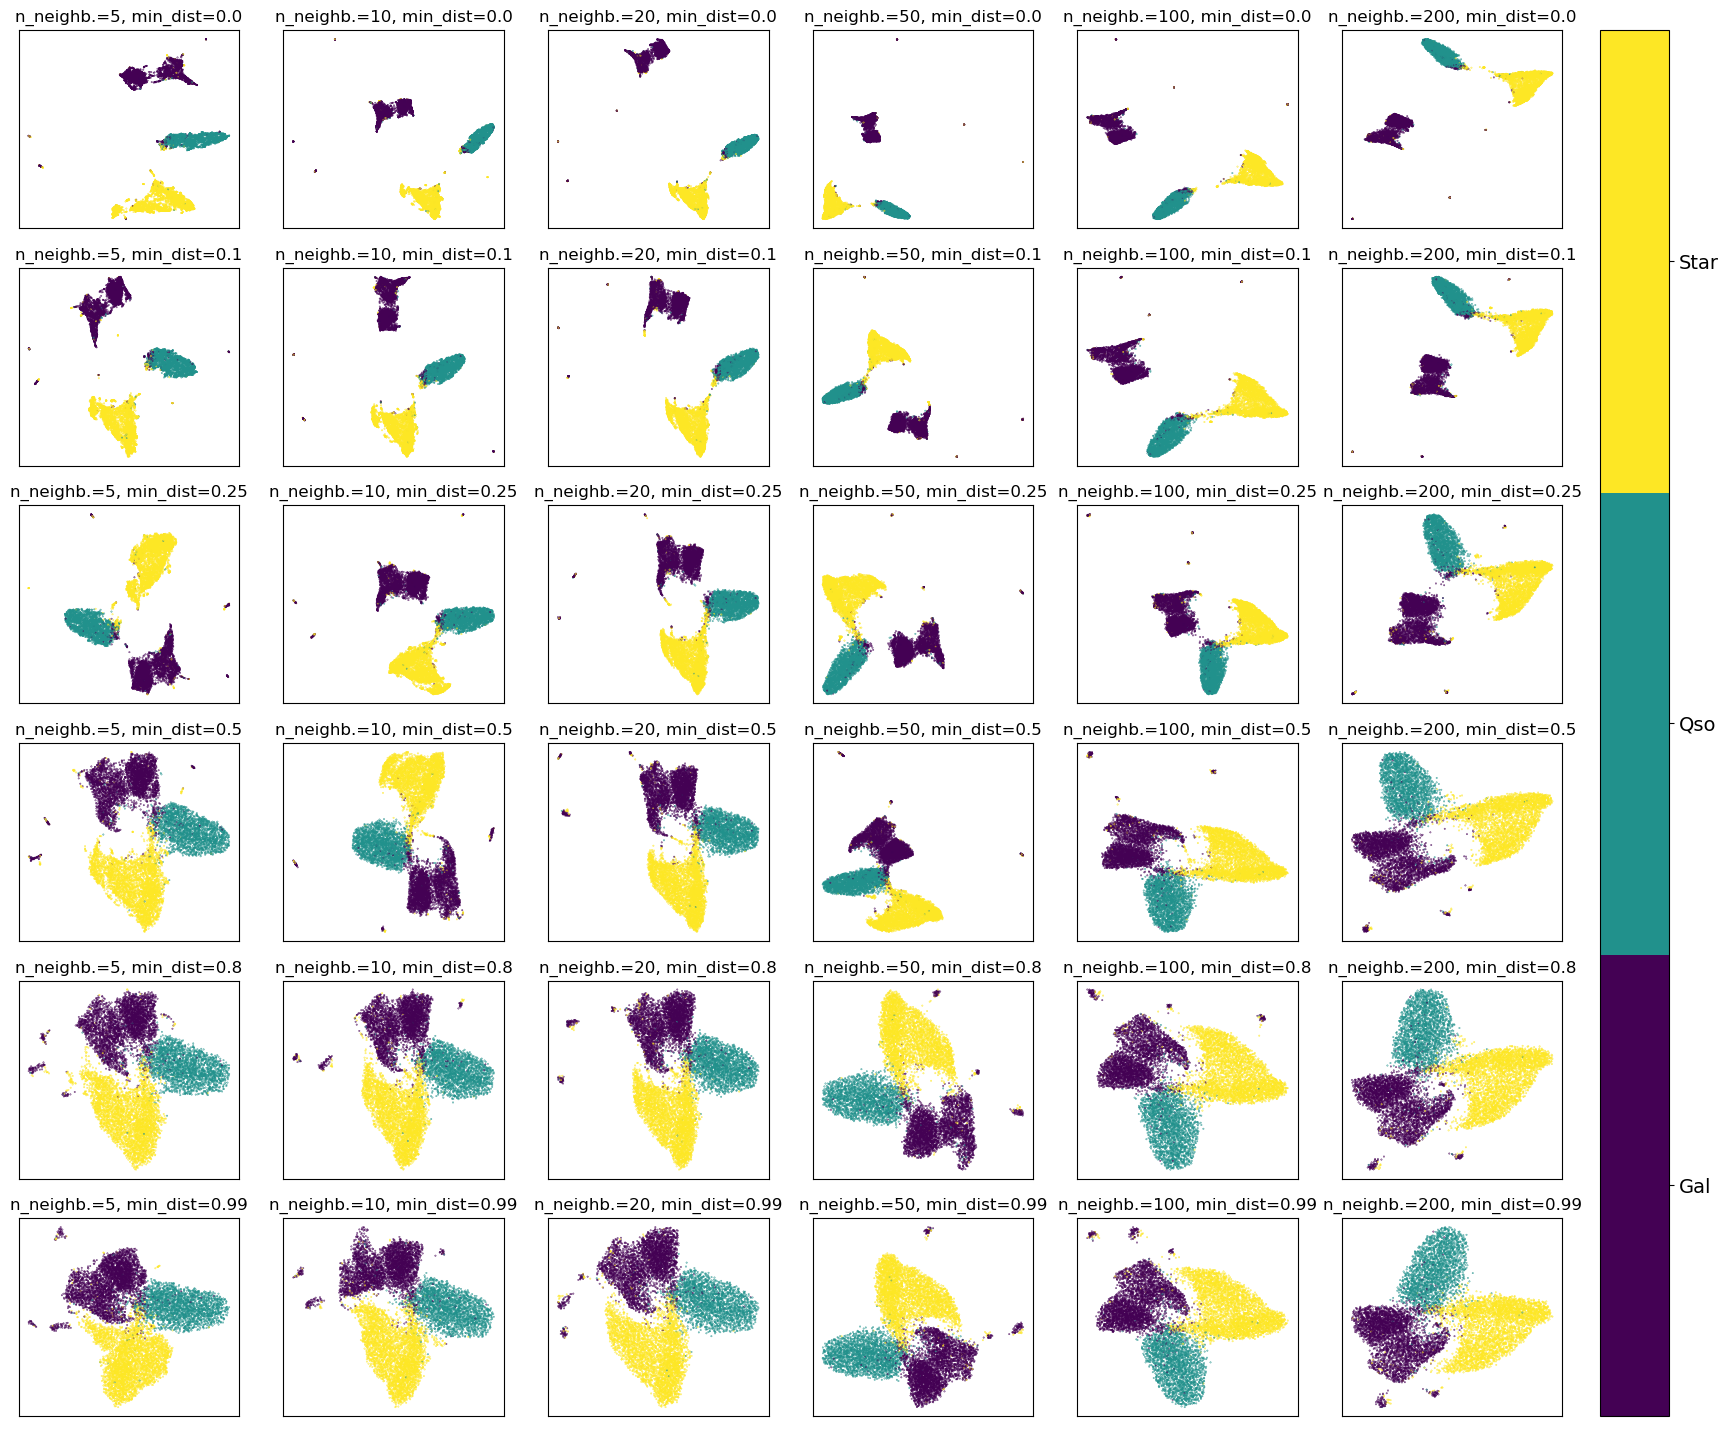

In [23]:
# Hyperparameter tests: n_neighbors vs. min_dist

n_neighbors_values = [5, 10, 20, 50, 100, 200]
min_dist_values = [0.0, 0.1, 0.25, 0.5, 0.8, 0.99]
cmap = 'viridis'

fig, axes = plt.subplots(6, 6, figsize=(24, 18))
#emb2v2 = []
idx = 0
for i,n in enumerate(n_neighbors_values):
    for j,min_dist in enumerate(min_dist_values):
        #embedding = umap.UMAP(n_neighbors=n, min_dist=min_dist).fit_transform(data)
        #emb2v2.append(embedding)
        embedding = emb2v2[idx]
        p = axes[j,i].scatter(embedding[:, 0], embedding[:, 1], c=target, s=0.1, cmap=cmap)
        axes[j,i].set_title(f'n_neighb.={n}, min_dist={min_dist}')
        axes[j,i].xaxis.set_ticks([])
        axes[j,i].yaxis.set_ticks([])
        #print(f'Finished ax {i},{j}.')
        idx += 1

cbar = fig.colorbar(p, ax=axes, location='right', pad=0.02, boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=14)

plt.savefig('figures/umap_n_neighbors_vs_min_dist.png', dpi=250)
plt.show()

In [24]:
# Hyperparameters test: metric

metrics_values = ['euclidean',
                  'manhattan',
                  'chebyshev',
                  'minkowski',
                  'canberra',
                  #'braycurtis',
                  'mahalanobis',
                  'wminkowski',
                  'cosine',
                  'correlation']

embeddings_metrics = []
for m in metrics_values:
    try:
        embedding = umap.UMAP(n_neighbors=100, min_dist=0.25, metric=m).fit_transform(data)
    except:
        print(f"Failed with {m} distance metric.")
        continue
    embeddings_metrics.append(embedding)
    print(f"Finished UMAP with {m} distance metric.")

Finished UMAP with euclidean distance metric.
Finished UMAP with manhattan distance metric.
Finished UMAP with chebyshev distance metric.
Finished UMAP with minkowski distance metric.
Finished UMAP with canberra distance metric.
Finished UMAP with mahalanobis distance metric.
Finished UMAP with wminkowski distance metric.
Finished UMAP with cosine distance metric.
Finished UMAP with correlation distance metric.


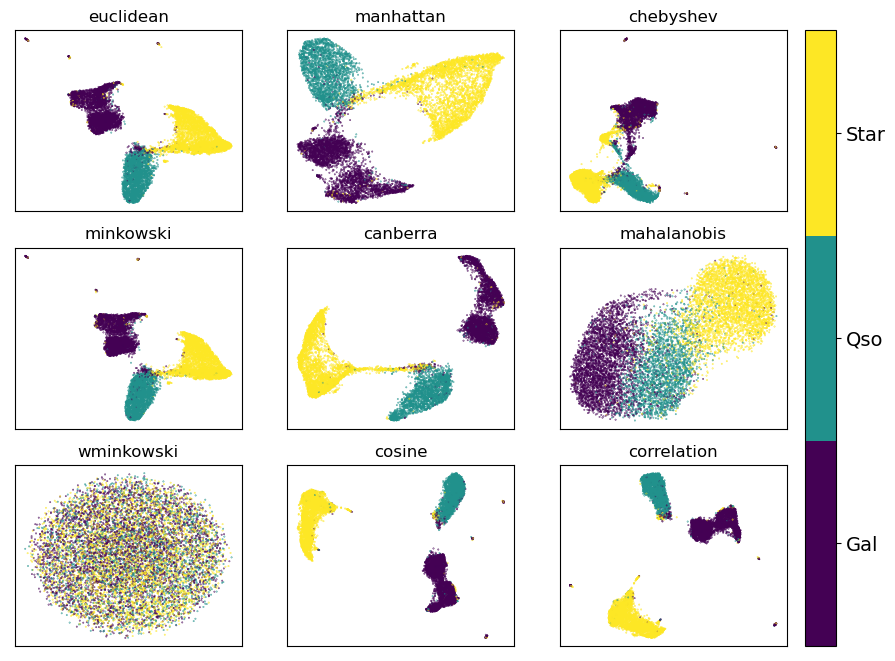

In [25]:
# Plotting metric tests

cmap = 'viridis'
fig, axes = plt.subplots(3, 3, figsize=(12, 8))
idx = 0
for i in range(3):
    for j in range(3):
        current_emb = embeddings_metrics[idx]
        current_metric = metrics_values[idx]
        ax = axes[i,j]
        p = ax.scatter(current_emb[:, 0], current_emb[:, 1], c=target, s=0.1, cmap=cmap)
        ax.set_title(f'{current_metric}')
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        idx += 1

cbar = fig.colorbar(p, ax=axes, location='right', pad=0.02, boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(classes)
cbar.ax.tick_params(labelsize=14)

plt.savefig('figures/umap_metrics.png', dpi=250)
plt.show()

### UMAP embedding plot: static vs. interactive

In [29]:
%%time

# Single UMAP call
embedding = umap.UMAP(n_neighbors=100, min_dist=0.1, n_components=2).fit_transform(data)

CPU times: user 2min 59s, sys: 3.6 s, total: 3min 3s
Wall time: 28.2 s


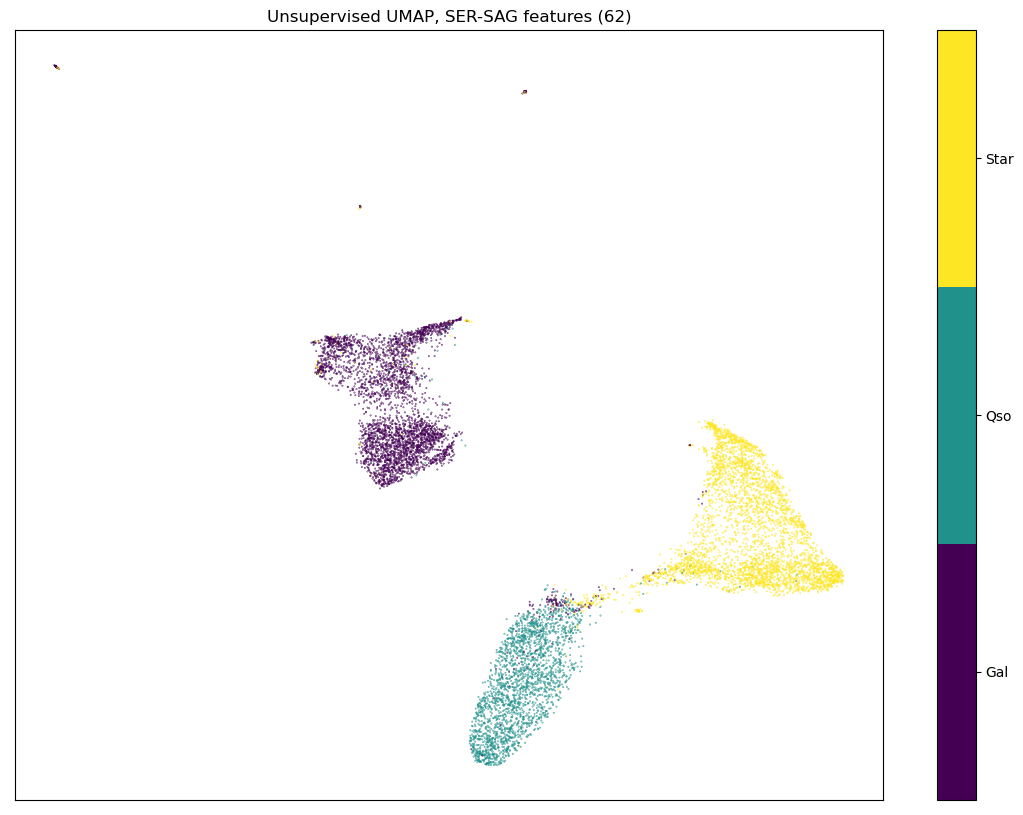

In [30]:
# Static plot

fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='viridis', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(classes)
plt.title(f'Unsupervised UMAP, SER-SAG features ({X.shape[1]})')
plt.show()
#plt.savefig('umap_test.png', dpi=300)

In [28]:
# Interactive plot with bokeh

#embedding = umap.UMAP(n_neighbors=100, min_dist=0.25, n_components=2).fit_transform(data)

In [31]:
hover_data = pd.DataFrame({'index':sample.index,
                           'label':target})
hover_data['item'] = hover_data.label.map(
    {
        0:'Gal',
        1:'Qso',
        2:'Star',
        #3:'vStar',
    }
)

In [32]:
# Create a Bokeh data source
source = ColumnDataSource(data=dict(emb_x=embedding[:, 0], emb_y=embedding[:, 1], target=target, labels=hover_data['item'], index=hover_data['index']))

# Create a colormap and color mapper
mapper = linear_cmap(field_name='target', palette=Viridis3, low=-0.5, high=2.5)

# Create the figure
p = figure(width=800, height=600, title=f'Unsupervised UMAP, SER-SAG features ({X.shape[1]})', tools="pan,wheel_zoom,box_zoom,reset,save")

# Create the scatter plot
p.scatter(x='emb_x', y='emb_y', size=4, source=source, color=mapper, legend_field="labels", fill_alpha=0.6)

# Create the hover tool
hover = HoverTool()
hover.tooltips = [("Index", "$index"), ("Label", "@labels")]
p.add_tools(hover)

# Create the colorbar
custom_labels = ['Gal', 'Qso', 'Star']#, 'vStar']
color_bar = ColorBar(color_mapper=mapper['transform'], width=15, location=(0,0), ticker=BasicTicker(desired_num_ticks=3), label_standoff=12)
color_bar.major_label_overrides = {0:'Gal',1:'Qso',2:'Star'}#,3:'vStar'}
p.add_layout(color_bar, 'right')

# Remove axis labels
#p.xaxis.major_label_text_font_size = '0pt'
#p.yaxis.major_label_text_font_size = '0pt'

# Show the plot
output_notebook()
show(p)

Loading BokehJS ...

### Clustering with HDBSCAN

In [15]:
embedding = umap.UMAP(n_neighbors=100, min_dist=0.1, n_components=2).fit_transform(data)

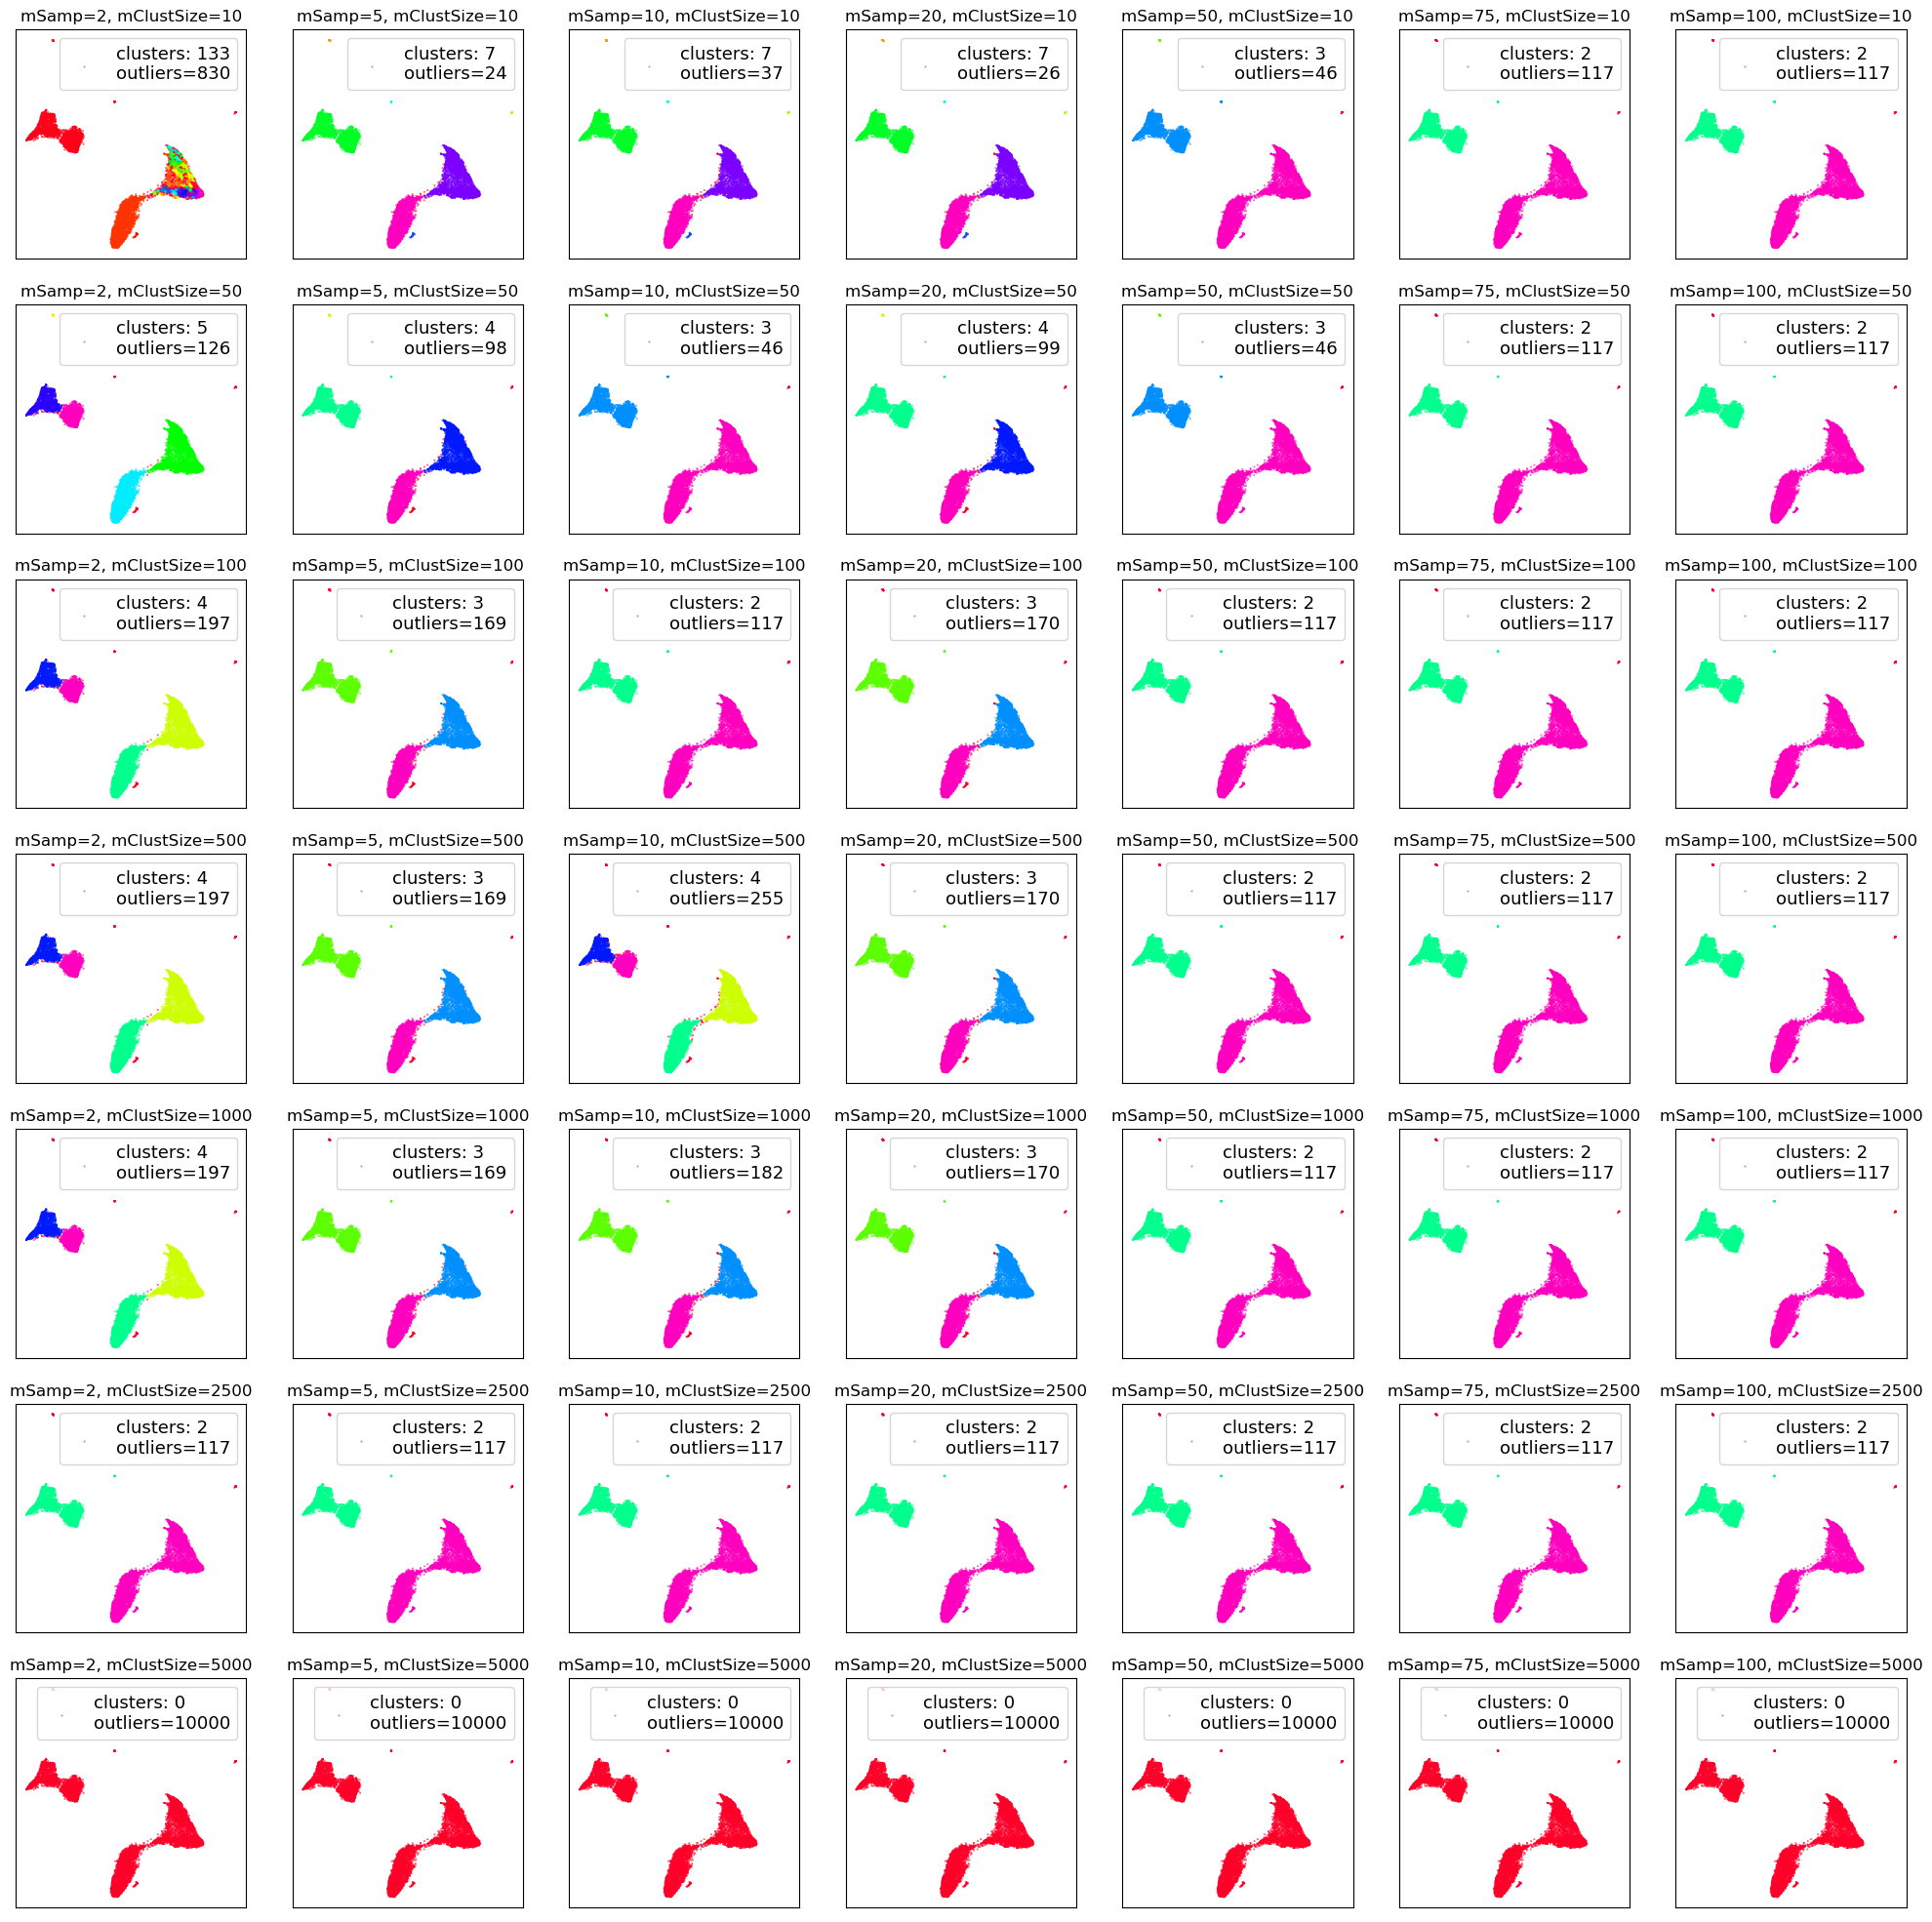

In [47]:
# HDBSCAN hyperparameter tests: min_samples vs. min_cluster_size

min_samples = [2, 5, 10, 20, 50, 75, 100]
min_cluster_size = [10, 50, 100, 500, 1000, 2500, 5000]
cmap = 'gist_rainbow'

fig, axes = plt.subplots(7, 7, figsize=(25,25))#(30, 26))
#pred_list = []
idx=0
for i, ms in enumerate(min_samples):
    for j, mcs in enumerate(min_cluster_size):
        #pred = HDBSCAN(min_samples=ms, min_cluster_size=mcs).fit_predict(embedding)
        #pred_list.append(pred)
        pred = pred_list[idx]
        num_clusters = len(np.unique(pred[pred>=0]))
        num_outliers = len(pred[pred==-1])
        other = len(pred[pred<-1])
        #print(f"num_clusters: {num_clusters}")
        #print(f"num_outliers: {num_outliers}")
        #print(f"num_other: {other}")
        p = axes[j,i].scatter(embedding[:, 0],
                              embedding[:, 1],
                              c=pred,
                              cmap=cmap,
                              s=0.1,
                              label=f'clusters: {num_clusters}\noutliers={num_outliers}')
        axes[j,i].set_title(f'mSamp={ms}, mClustSize={mcs}')
        axes[j,i].xaxis.set_ticks([])
        axes[j,i].yaxis.set_ticks([])
        axes[j,i].legend(fontsize=13)
        idx += 1

plt.show()

Ideal combination of parameters for clustering (3 clusters: Galaxies, Stars and QSO):

- `min_samples = 5`
- `100 < min_cluster_size < 1000`

In [59]:
labels = HDBSCAN(
    min_samples=5,
    min_cluster_size=400,
).fit_predict(embedding)

No handles with labels found to put in legend.


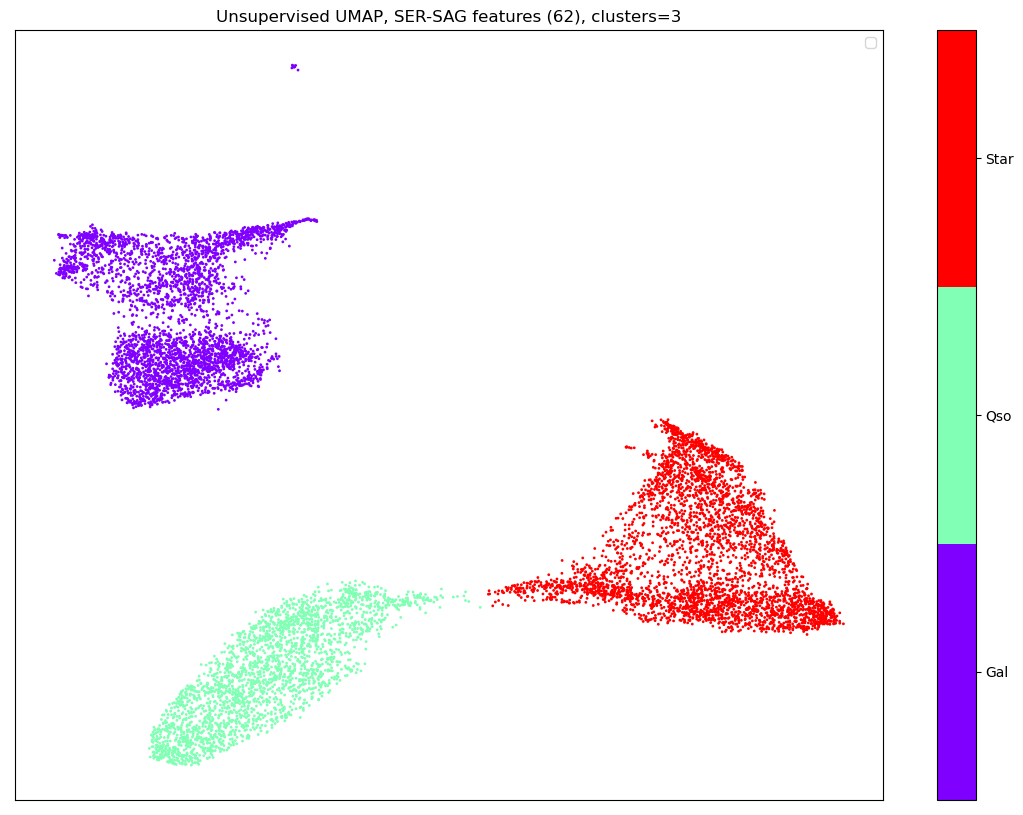

In [60]:
fig, ax = plt.subplots(1, figsize=(14, 10))
#plt.scatter(embedding[:,0][labels==-1], embedding[:,1][labels==-1], s=5, c='k', label='Outliers')
plt.scatter(embedding[:,0][labels>=0], embedding[:,1][labels>=0], s=1, c=labels[labels>=0], cmap='rainbow', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(['Gal', 'Qso', 'Star'])
plt.title(f'Unsupervised UMAP, SER-SAG features ({X.shape[1]}), clusters=3')
plt.legend()
plt.show()
#plt.savefig('umap_test.png', dpi=300)

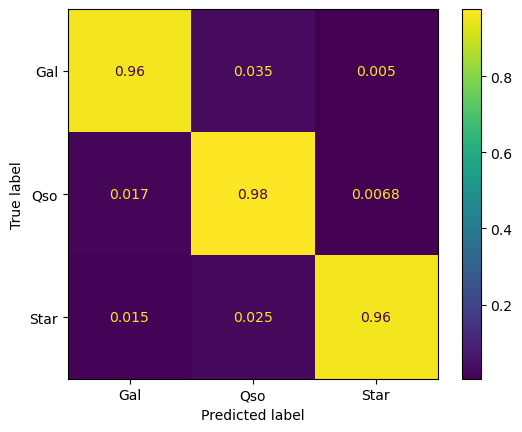

In [66]:
my_dict = {0:'Gal',1:'Qso',2:'Star'}
pred_lab = np.vectorize(my_dict.get)(labels)
true_lab = np.vectorize(my_dict.get)(target)

cm = confusion_matrix(true_lab[labels>=0], pred_lab[labels>=0], normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Gal','Qso','Star'])
disp.plot()
plt.show()

Another interesting case are 4 cluster embeddings where galaxies have two subclasses:

- `min_samples = 2`
- `100 < min_cluster_size < 1000`

In [18]:
labels = HDBSCAN(
    min_samples=2,
    min_cluster_size=500,
).fit_predict(embedding)

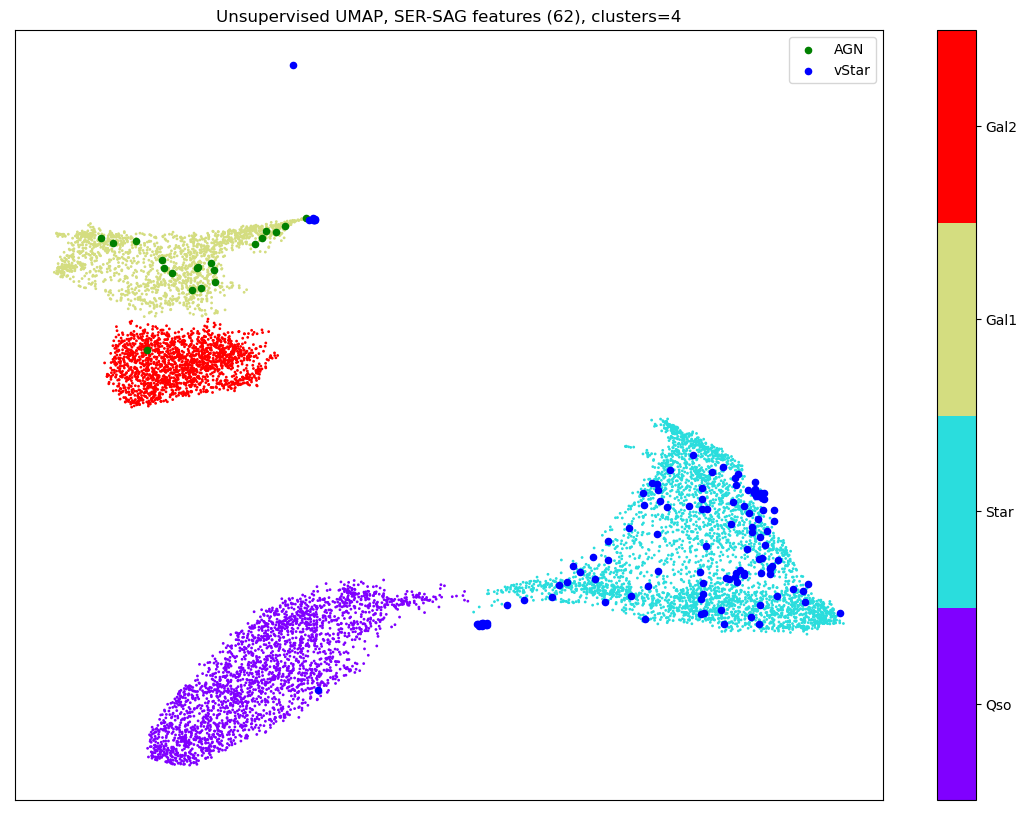

In [46]:
fig, ax = plt.subplots(1, figsize=(14, 10))

# main plot
plt.scatter(embedding[:,0][labels>=0], embedding[:,1][labels>=0], s=1, c=labels[labels>=0], cmap='rainbow', alpha=1.0)
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(['Qso', 'Star', 'Gal1', 'Gal2'])

# addiional data
#plt.scatter(embedding[:,0][labels==-1], embedding[:,1][labels==-1], s=5, c='gray', label='Outliers')
plt.scatter(embedding[:,0][target_old == 's82Agn'], embedding[:,1][target_old == 's82Agn'], s=20, c='g', label='AGN')
plt.scatter(embedding[:,0][target_old == 's82vStar'], embedding[:,1][target_old == 's82vStar'], s=20, c='b', label='vStar')
plt.setp(ax, xticks=[], yticks=[])

plt.title(f'Unsupervised UMAP, SER-SAG features ({X.shape[1]}), clusters=4')
plt.legend()
plt.show()
#plt.savefig('umap_test.png', dpi=300)

- We can see now that majority of AGN (Seyfert galaxies) populate upper galaxy cluster (Gal1).
- As expected, variable stars are close to Star cluster. Some of them explain outliers/edge cases near that cluster.

## Supervised UMAP

In [75]:
%%time
embedding = umap.UMAP().fit_transform(data, y=target)

CPU times: user 20min 42s, sys: 2min 34s, total: 23min 16s
Wall time: 3min 42s


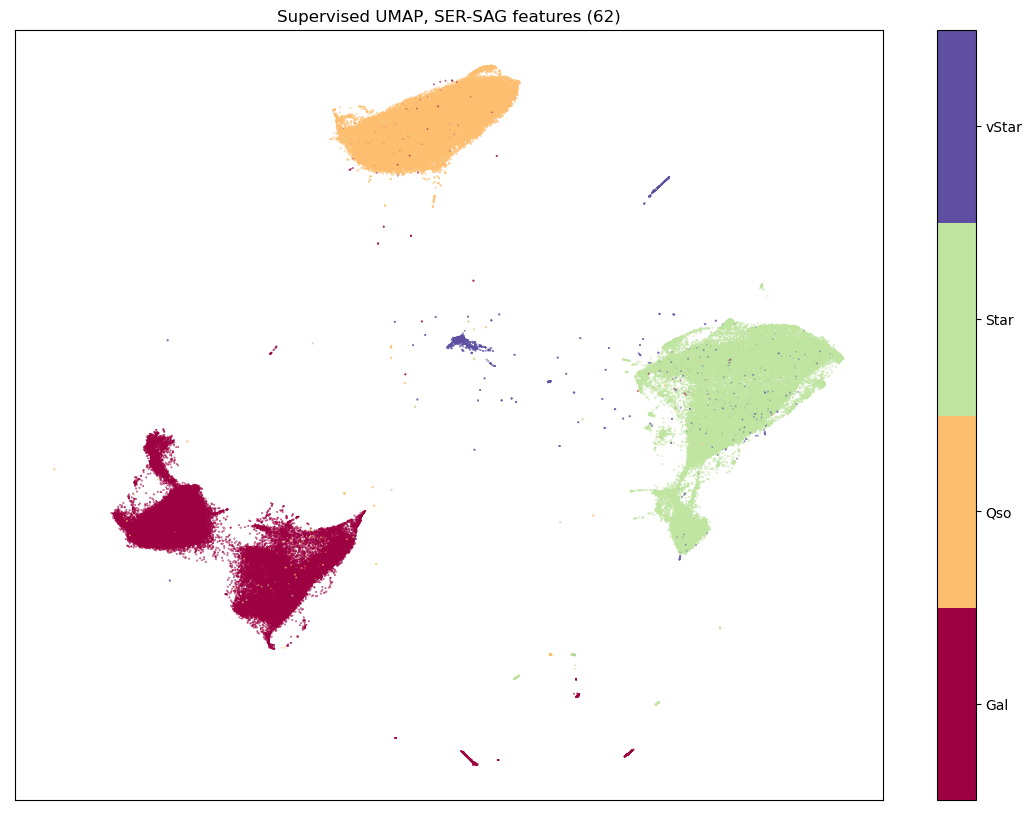

In [85]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=0.1, c=target, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(5)-0.5)
cbar.set_ticks(np.arange(4))
cbar.set_ticklabels(classes)
plt.title(f'Supervised UMAP, SER-SAG features ({X.shape[1]})')
plt.show()
#plt.savefig('umap_test.png', dpi=300)